In [662]:
import boto3
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import misc
pd.set_option('display.max_colwidth', 300)
from IPython.display import Markdown as md

In [431]:
# ! curl -o waypoints.png https://raw.githubusercontent.com/aws-samples/aws-deepracer-workshops/master/Workshops/2019-AWSSummits-AWSDeepRacerService/Lab1/img/reinventtrack_waypoints.png 

In [506]:
# Con este recorte queda de exactamente 8x5
waypoints_img = misc.imread('waypoints.png')[185:1313, 605:2467]

/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


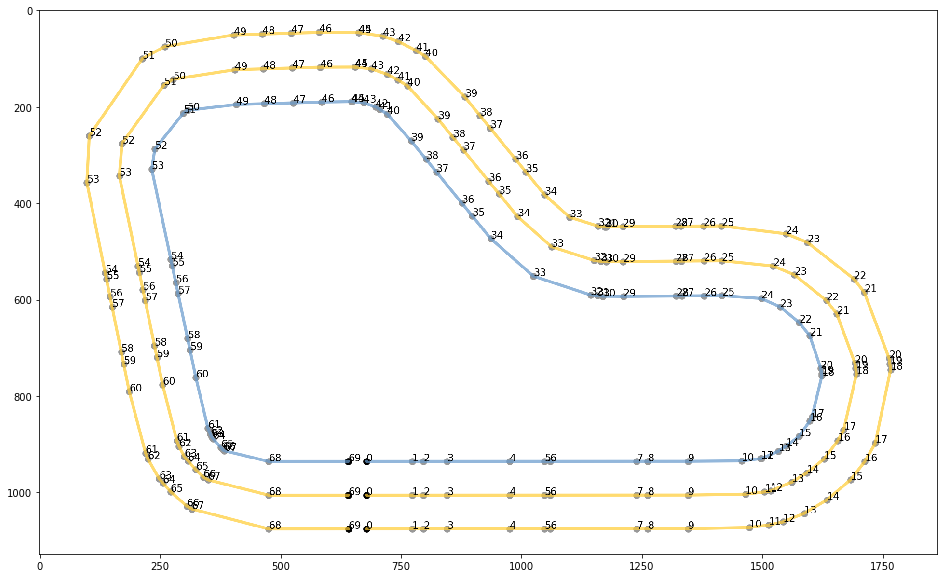

In [507]:
plt.figure(figsize=(20,10))
plt.imshow(waypoints_img)
plt.show()

In [269]:
# https://docs.aws.amazon.com/deepracer/latest/developerguide/deepracer-console-train-evaluate-models.html
# https://docs.aws.amazon.com/deepracer/latest/developerguide/deepracer-reward-function-input.html
# https://raw.githubusercontent.com/aws-samples/aws-deepracer-workshops/master/Workshops/2019-AWSSummits-AWSDeepRacerService/Lab1/img/reinventtrack_waypoints.png

In [2]:
client = boto3.client('logs')

In [546]:
logGroupName='/aws/robomaker/SimulationJobs'
# LR-REDUCER-8ms
logStreamName='sim-vwz2wmvkvzfc/2019-10-02T10-16-11.514Z_597c6d87-0f6b-418e-acc5-5b6cce204276/SimulationApplicationLogs'
# 12MperS--LR-0-000001-clone-4
# logStreamName='sim-r6hh2fj4k19s/2019-10-07T11-26-26.204Z_fb770f02-52fd-4f94-8656-2874266cd7bb/SimulationApplicationLogs'
file_name = logStreamName.split('/')[0]

In [547]:
resp = None

In [548]:
resp = json.load(open(f'{file_name}.json'))

In [549]:
def get_log(logGroupName, logStreamName):
    kwargs = {
            'logGroupName': logGroupName,
            'logStreamNames': [logStreamName], 
            'limit': 10000,
        }
    
    while True:
        resp = client.filter_log_events(**kwargs)
        yield from resp['events']
        try:
            kwargs['nextToken'] = resp['nextToken']
        except KeyError:
            break

In [550]:
if resp is None:
    resp = [x for x in get_log(logGroupName, logStreamName)]
    file = open(f'{file_name}.json', 'w')
    json.dump(resp, file)
    file.close()

In [551]:
df = pd.DataFrame(resp)[['message', 'timestamp']]

In [552]:
# df.iloc[180:250]

In [640]:
trace = df[df['message'].apply(lambda x: 'SIM_TRACE_LOG:' in x)]

In [641]:
trace_df = pd.DataFrame([x for x in trace['message'].apply(lambda x: x.split('SIM_TRACE_LOG:')[1].split(','))], 
                        columns=['episode', 'step', 'x-coordinate', 'y-coordinate', 'heading', 'steering_angle', 'speed', 'action_taken', 
                                 'reward', 'job_completed', 'all_wheels_on_track', 'progress',  'closest_waypoint_index', 'track_length', 
                                 'time'])


In [643]:
trace_df = trace_df.astype({'episode': 'int32', 'step': 'int32', 'x-coordinate': 'float', 'y-coordinate': 'float', 'progress': 'float', 
                            'time': 'double', 'speed': 'float', 'reward': 'float', 'closest_waypoint_index': 'int32', 'heading': 'float'})

In [644]:
trace_df.head()

,episode,step,x-coordinate,y-coordinate,heading,steering_angle,speed,action_taken,reward,job_completed,all_wheels_on_track,progress,closest_waypoint_index,track_length,time
0,0,0,3.0500,0.6832,0.0004,0.00,0.00,0,0.0000,False,True,0.7922,0,17.67,1.570012e+09
1,0,1,3.0500,0.6832,0.0003,-0.52,2.67,0,0.3333,False,True,0.7922,0,17.67,1.570012e+09
2,0,0,3.0500,0.6833,0.0005,0.00,0.00,0,0.0000,False,True,0.7921,0,17.67,1.570012e+09
3,0,1,3.0502,0.6832,-0.0003,0.52,8.00,14,1.0000,False,True,0.7931,0,17.67,1.570012e+09
4,0,2,3.0587,0.6813,-0.0090,0.52,5.33,13,0.6667,False,True,0.8416,0,17.67,1.570012e+09


# Primeros 20 episodios de entrenamiento

In [645]:
import matplotlib as mpl
mpl.style.use('default')

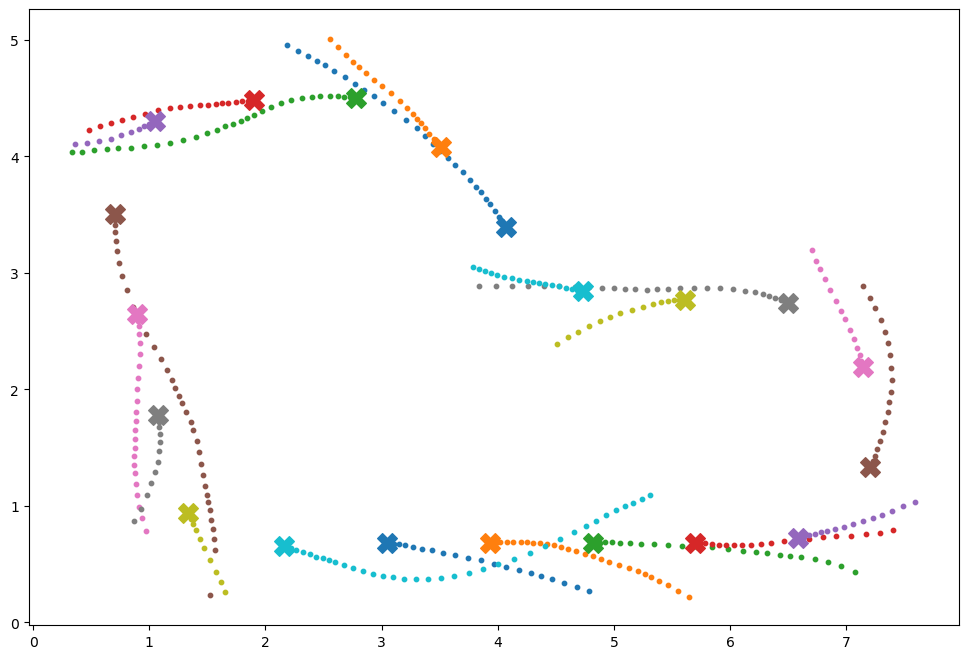

In [646]:
plt.figure(figsize=(12,8))
for i in range(20):
    episode = trace_df[trace_df['episode'] == i]
    plt.scatter(episode['x-coordinate'].iloc[0], episode['y-coordinate'].iloc[0], marker='X', s=200, c=f'C{i}')
    plt.scatter(episode['x-coordinate'], 
                episode['y-coordinate'], s=10, c=f'C{i}')
plt.show()

In [667]:
training_hours = 1
episode_after_some_time = min(trace_df[((trace_df['time'] - trace_df['time'].iloc[0])/3600)>training_hours]['episode'])

md("# Luego de %i horas de entrenamiento"%(training_hours))

# Luego de 1 horas de entrenamiento

600


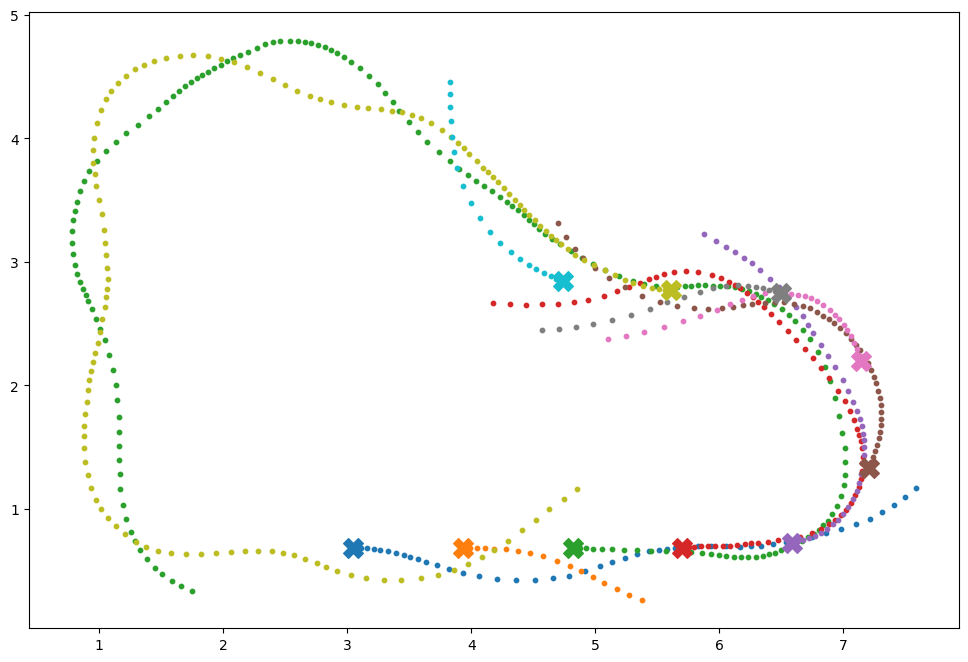

In [668]:
plt.figure(figsize=(12,8))

print(episode_after_some_time)
for i in range(10):
    episode = trace_df[trace_df['episode'] == episode_after_some_time + i]
    plt.scatter(episode['x-coordinate'].iloc[0], episode['y-coordinate'].iloc[0], 
                marker='X', s=200, c=f'C{i}')
    plt.scatter(episode['x-coordinate'], 
                episode['y-coordinate'], s=10, c=f'C{i}')
plt.show()

# Episodios donde la pista se completa

In [671]:
finished_episodes = trace_df[(trace_df['progress'] == 100)]['episode'].values

In [672]:
episode = trace_df[trace_df['episode'] == finished_episodes[0]] 
meters_drove = ((episode['x-coordinate'].diff(1).values[1:]**2 + episode['y-coordinate'].diff(1).values[1:]**2)**(0.5)).sum()

Time
14.401840360725627 1.056458263681007
Speed
4.621505660620976 0.24381955695292662
Steps
215.73529411764707 15.829623799047695
Rewards
142.4290125 29.048182470219242
Meters drove
17.931448092848658 0.7282059324604571


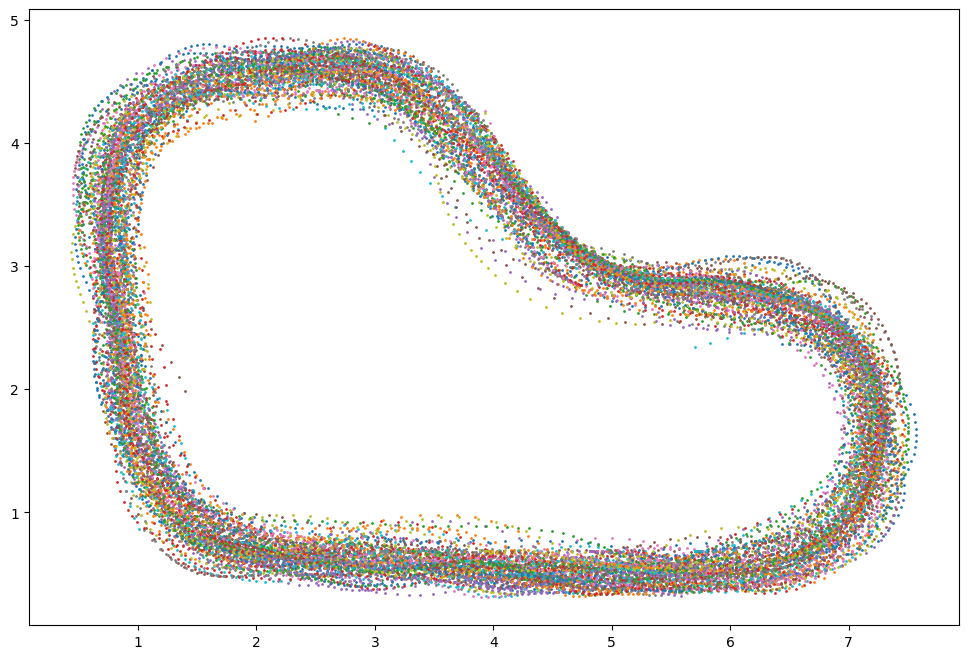

In [673]:
episode = 500
plt.figure(figsize=(12,8))
track_time = []
speeds = []
steps = []
acc_reward = []
meters_drove = []
for i in finished_episodes:
    episode = trace_df[trace_df['episode'] == i]
    plt.scatter(episode['x-coordinate'], 
                episode['y-coordinate'], s=1)
    track_time.append(episode.iloc[-1]['time'] - episode.iloc[0]['time'])
    speeds.append(episode['speed'].mean())
    steps.append(episode['step'].iloc[-1])
    meters_drove.append(((episode['x-coordinate'].diff(1).values[1:]**2 + episode['y-coordinate'].diff(1).values[1:]**2)**(0.5)).sum())
    acc_reward.append(episode['reward'].sum())
track_time = np.array(track_time)
speeds = np.array(speeds)
steps = np.array(steps)
acc_reward = np.array(acc_reward)
meters_drove = np.array(meters_drove)
print('Time')
print(track_time.mean(), track_time.std())
print('Speed')
print(speeds.mean(), speeds.std())
print('Steps')
print(steps.mean(), steps.std())
print('Rewards')
print(acc_reward.mean(), acc_reward.std())
print('Meters drove')
print(meters_drove.mean(), meters_drove.std())
plt.show()

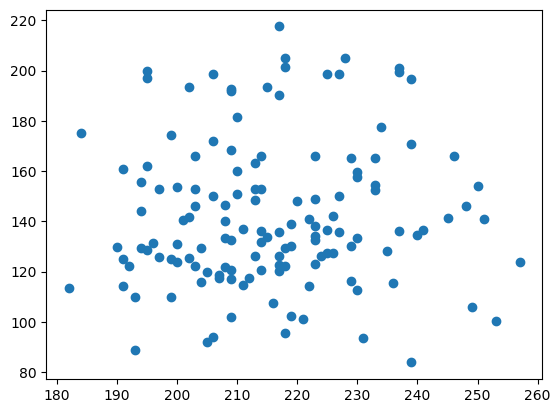

In [674]:
plt.scatter(steps, acc_reward)
plt.show()

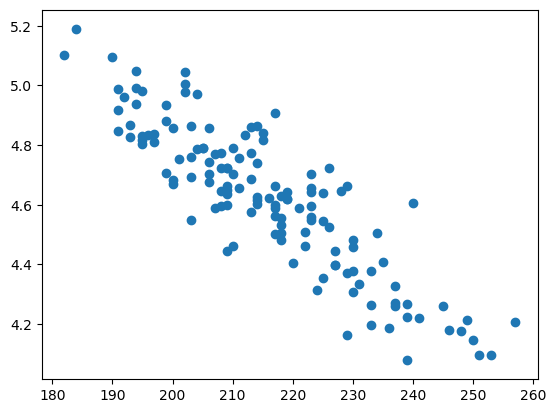

In [675]:
plt.scatter(steps, speeds)
plt.show()

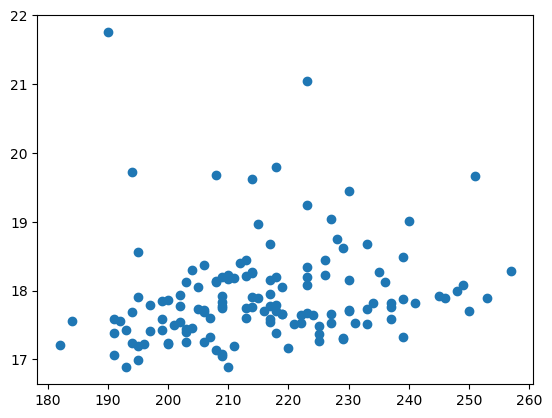

In [676]:
plt.scatter(steps, meters_drove)
plt.show()

In [677]:
min(episode['heading']), max(episode['heading'])

(-3.1263, 3.1112)

In [678]:
min(episode['closest_waypoint_index']), max(episode['closest_waypoint_index'])

(0, 70)

In [679]:
len(episode)

196

# Lugares donde el reward es bajo (speed normalizada mucho menor que reward) - Sospechoso

time: 12.883181095123291
Frames per second: 15.05839268792359


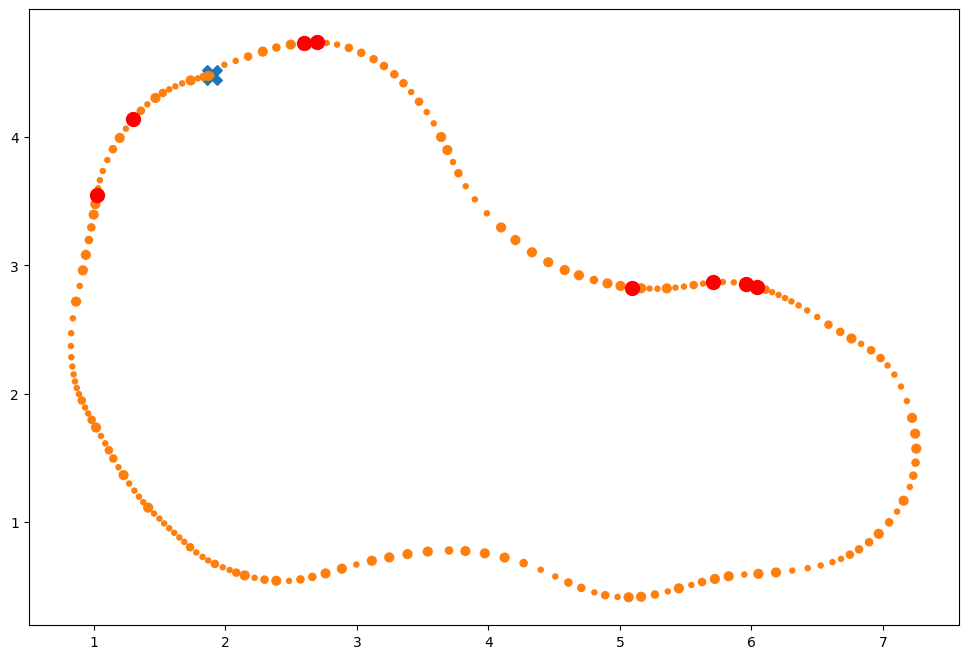

In [680]:
plt.figure(figsize=(12,8))
n_episode = 0
episode = trace_df[trace_df['episode'] == finished_episodes[n_episode]]

dif_reg_speed = episode[(episode['reward'] - episode['speed']/max(episode['speed']))<-0.5]
plt.scatter(episode['x-coordinate'].iloc[0], episode['y-coordinate'].iloc[0], marker='X', s=200)

plt.scatter(episode['x-coordinate'], 
            episode['y-coordinate'], s=episode['speed']*5, cmap='gray') #c=episode['speed']/max(episode['speed'])

plt.scatter(dif_reg_speed['x-coordinate'], 
            dif_reg_speed['y-coordinate'], s=100, c='r')

print('time:',episode.iloc[-1]['time'] - episode.iloc[0]['time'])
print('Frames per second:',1/((episode.iloc[-1]['time'] - episode.iloc[0]['time'])/len(episode)))
plt.show()

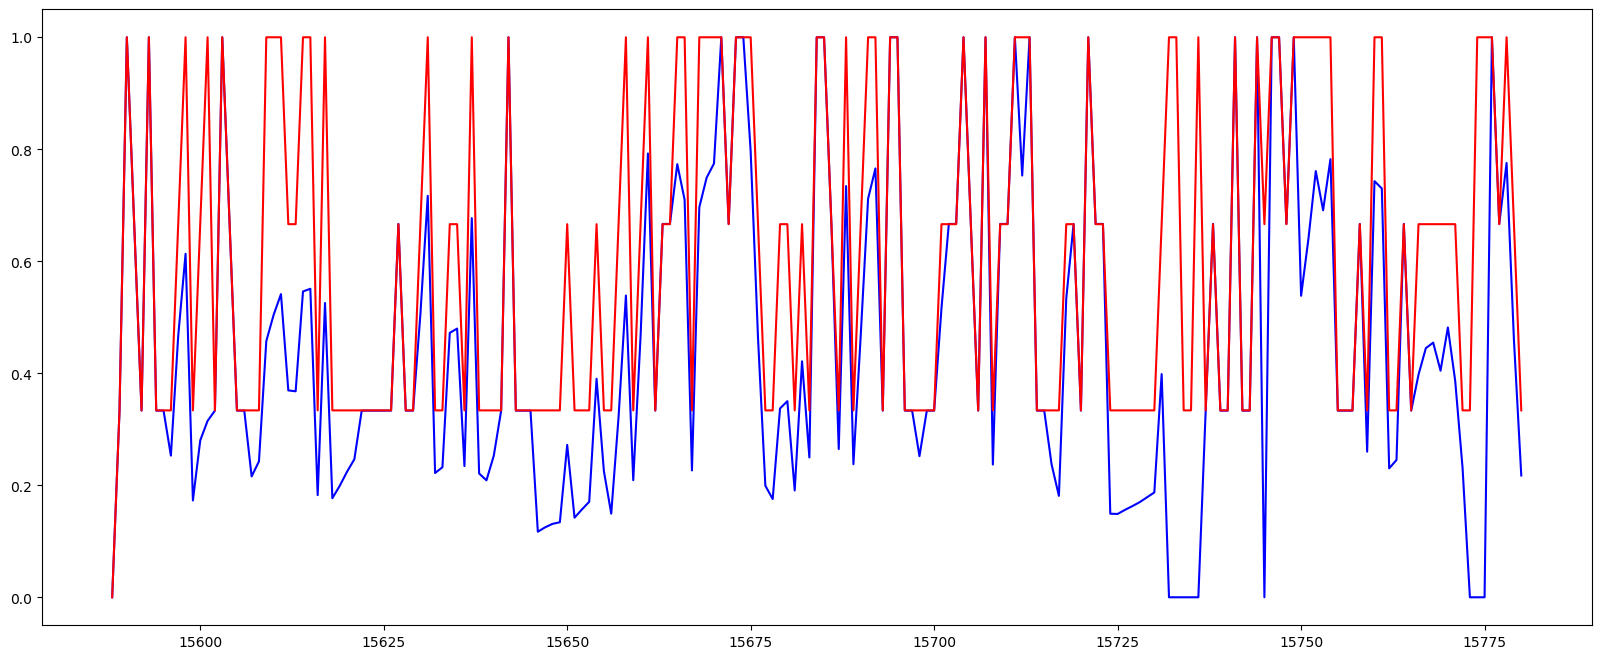

In [681]:
plt.figure(figsize=(20,8))
plt.plot(episode['reward'][:-1], c='b')
plt.plot(episode['speed'][:-1]/max(episode['speed']), c='r')
plt.show()

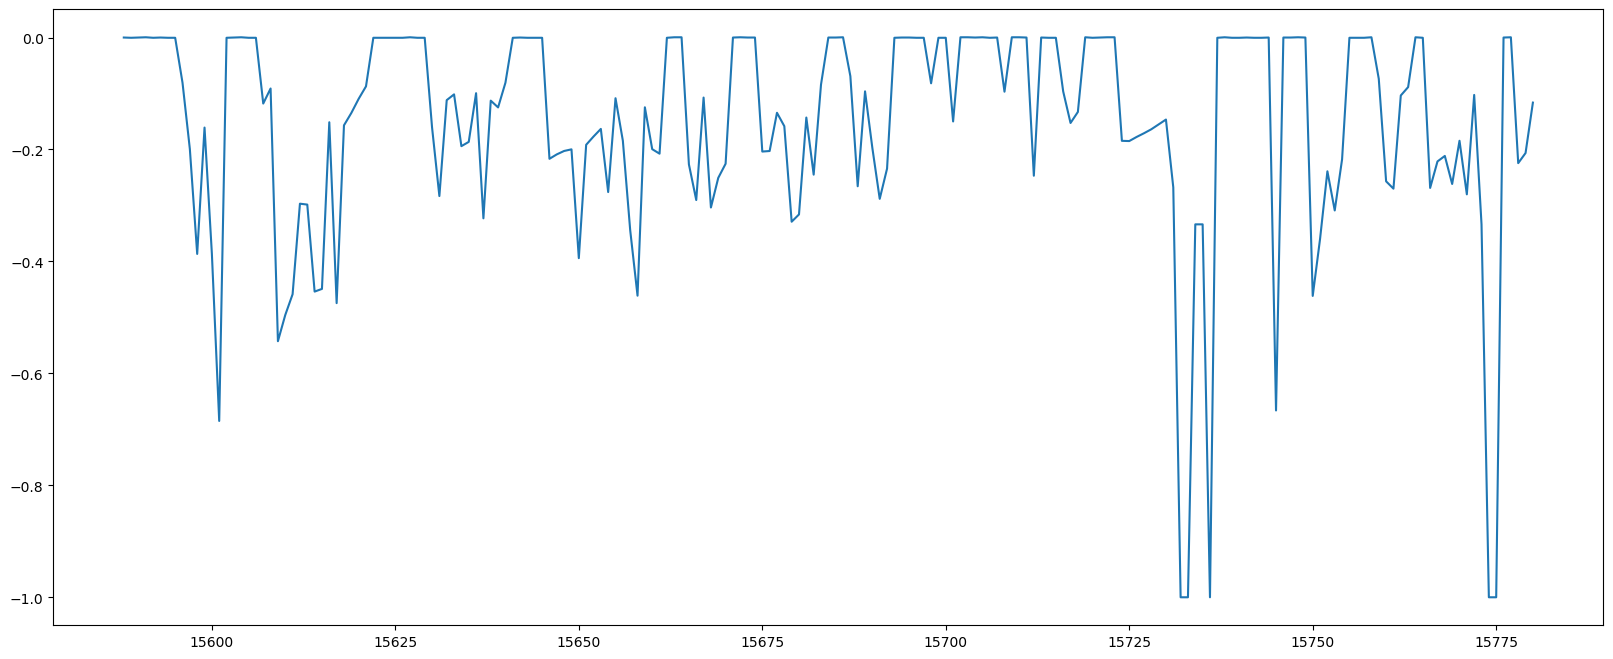

In [682]:
plt.figure(figsize=(20,8))
plt.plot(episode['reward'][:-1] - episode['speed'][:-1]/max(episode['speed']))
plt.show()

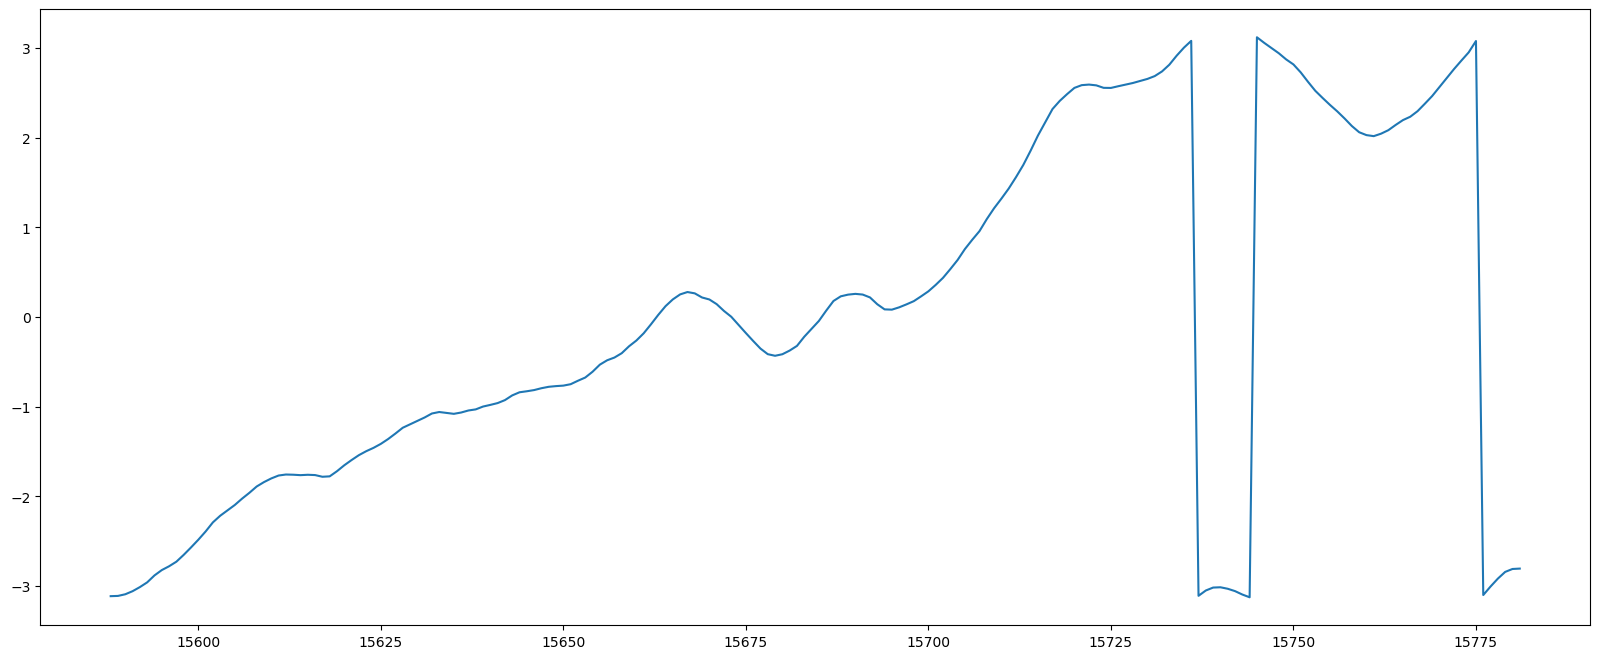

In [684]:
# Esto es muy sospechoso, hay que arreglarlo
plt.figure(figsize=(20,8))
plt.plot(episode['heading'])
plt.show()

# Last 10 episodes

In [685]:
n_episodes = max(trace_df['episode'])

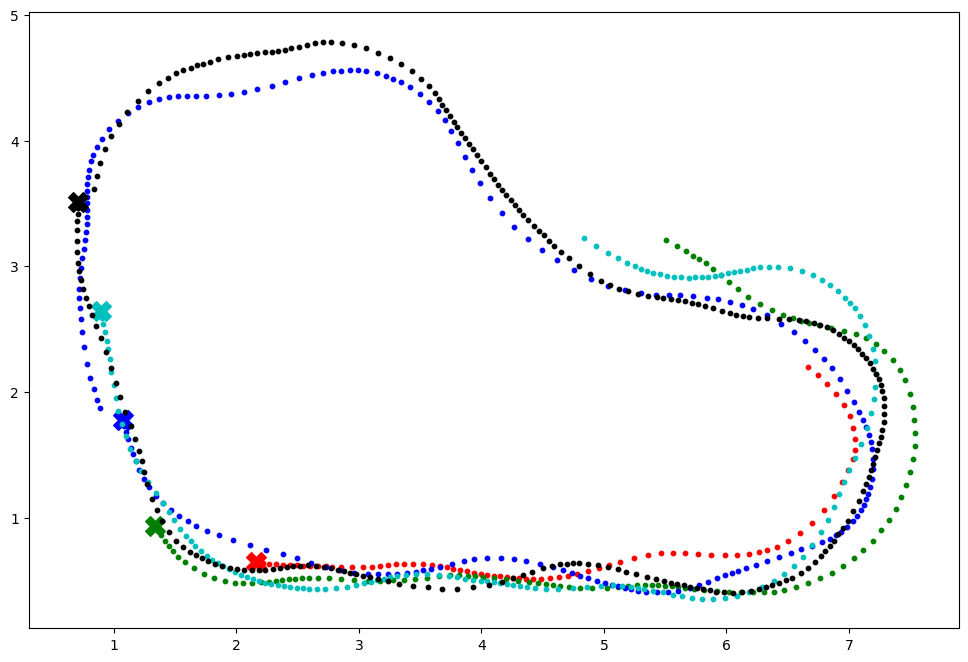

In [686]:
plt.figure(figsize=(12,8))
for i in range(5):
    episode = trace_df[trace_df['episode'] == n_episodes-i]
    colors = ['r', 'g', 'b', 'c', 'k']
    plt.scatter(episode['x-coordinate'].iloc[0], episode['y-coordinate'].iloc[0], marker='X', s=200, c=colors[i%len(colors)])
    plt.scatter(episode['x-coordinate'], 
                episode['y-coordinate'], s=10, c=colors[i%len(colors)])
plt.show()

# Función de reward

In [509]:
import math
def reward_function(params):
    # track_width = params['track_width'] # Tamaño de pista
    # distance_from_center = params['distance_from_center'] # distance in meters from the track center 
    # steering = abs(params['steering_angle'])
    # direction_stearing=params['steering_angle']
    # steps = params['steps'] # number steps completed
    # all_wheels_on_track = params['all_wheels_on_track'] # flag to indicate if the vehicle is on the track
    
    speed = params['speed']
    
    progress = params['progress'] # percentage of track completed
    
    waypoints = params['waypoints']
    closest_waypoints = params['closest_waypoints']
    heading = params['heading'] # vehicle's yaw in degrees
    
    reward = 1.0
    
    if progress == 100:
        reward += 100
    
    # Calculate the direction of the center line based on the closest waypoints
    next_point = waypoints[closest_waypoints[1]]
    prev_point = waypoints[closest_waypoints[0]]
    # Calculate the direction in radius, arctan2(dy, dx), the result is (-pi, pi) in radians
    track_direction = math.atan2(next_point[1] - prev_point[1], next_point[0] - prev_point[0]) 
    # Convert to degree
    track_direction = math.degrees(track_direction)
    # Calculate the difference between the track direction and the heading direction of the car
    direction_diff = abs(track_direction - heading)
    
    if direction_diff > 180:
        direction_diff = 360 - direction_diff
    
    # Penalize the reward if the difference is too large
    DIRECTION_THRESHOLD = 10.0
    
    malus=1
    
    if direction_diff > DIRECTION_THRESHOLD:
        malus=1-(direction_diff/50)
        if malus<0 or malus>1:
            malus = 0
        reward *= malus
    
    reward *= speed/12
    
    return reward